This notebook was used to predict the knockdown changes in distal peaks and is in its original development stage. Predictions can be performed much easier in the multiDGD package.

In [1]:
import os
import anndata as ad
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from omicsdgd.functions._data_manipulation import load_testdata_as_anndata
from omicsdgd.dataset import omicsDataset
#os.chdir('/Users/dbm829/Documents/work/Projects/GitHub/omicsDGD/')

matplotlib.rcParams.update({'font.size': 8})

In [27]:
save_dir = "../../results/analysis/HiChIP_data/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
support_data_dir = "../../../data/support/"
data_dir = "../../../data/"
model_dir = "../../results/trained_models/human_bonemarrow/"

In [22]:
save_dir = "../../results/analysis/HiChIP_data/"

## load data and model

### load data

In [3]:
# first find associated peaks
rna_ref_df = pd.read_csv(support_data_dir+"human_bonemarrow_gene_id_to_name.csv")
ref_df = pd.read_csv(support_data_dir+"human_bonemarrow_atac_peak_locations_closest_genes.csv")

In [18]:
modality_switch = len(rna_ref_df)
print(modality_switch)

13431


In [4]:
# import small data subsets and model
# data_prefix = './data/human_bonemarrow/subsets/'
data_name = "human_bonemarrow"
adata = ad.read_h5ad(data_dir + data_name + ".h5ad")
train_indices = np.where(adata.obs["train_val_test"] == "train")[0]
trainset = adata[train_indices, :].copy()
test_indices = np.where(adata.obs["train_val_test"] == "test")[0]
testset = adata[test_indices, :].copy()
modality_switch = 13431
library = torch.cat(
    (
        torch.sum(
            torch.Tensor(testset.X.todense())[:, :modality_switch], dim=-1
        ).unsqueeze(1),
        torch.sum(
            torch.Tensor(testset.X.todense())[:, modality_switch:], dim=-1
        ).unsqueeze(1),
    ),
    dim=1,
)

### Load model

In [6]:
from omicsdgd import DGD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_seed = 37

dgd_name = "human_bonemarrow_l20_h2-3_rs37"

model = DGD.load(data=trainset, save_dir=model_dir, model_name=dgd_name)
print("loaded model")

print(testset.shape)
print(model.test_rep.z.shape)

CUDA Available: False
Number of GPUs: 0
using device:  cpu
check: modality names are  ['GEX', 'ATAC']

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True
loaded model
(6925, 129921)
torch.Size([6925, 20])


In [7]:
test_set = omicsDataset(
    testset,
    model.param_dict["modality_switch"],
    model.param_dict["scaling"],
    model.param_dict["clustering_variable(meta)"],
    model.param_dict["correction_variable"],
    model.param_dict["modalities"],
)

check: modality names are  ['GEX', 'ATAC']


## define functions

In [9]:
def get_gene_ids(gene_name):
    gene_id = rna_ref_df[rna_ref_df["gene_name"] == gene_name]["gene_id"].values[0]
    gene_idx = np.where(rna_ref_df["gene_name"] == gene_name)[0][0]
    return gene_id, gene_idx


def find_closest_peak(gene_location):
    chrom = int(gene_location.split(":")[0].split("chr")[1])
    start = gene_location.split(":")[1].split("-")[0]
    end = gene_location.split(":")[1].split("-")[1]
    sub_df = ref_df[ref_df["Chromosome"] == chrom]
    # now find the peaks that contain the gene
    sub_df = sub_df[
        ((sub_df["Start"] <= int(start)) & (sub_df["End"] >= int(end)))
        | (  # peak contains gene
            (sub_df["Start"] >= int(start)) & (sub_df["End"] <= int(end))
        )
        | (  # gene contains peak
            (sub_df["Start"] <= int(start)) & (sub_df["End"] >= int(start))
        )
        | (  # peak starts before gene
            (sub_df["Start"] <= int(end)) & (sub_df["End"] >= int(end))
        )  # peak ends after gene
    ]
    closest_peak = list(sub_df["idx"].values)
    return closest_peak


def find_closest_start_and_end(chrom, window_start, window_end):
    sub_df = ref_df[ref_df["Chromosome"] == int(chrom.split("chr")[-1])]
    start_distances = np.abs(sub_df["Start"] - window_start)
    end_distances = np.abs(sub_df["End"] - window_end)
    start_idx = np.argmin(start_distances)
    end_idx = np.argmin(end_distances)
    return sub_df.iloc[start_idx]["idx"].item(), sub_df.iloc[end_idx]["idx"].item()


def plot_gel(heatmap, gene_name, gene_loc):
    df_heatmap_1 = pd.DataFrame(
        heatmap.numpy(),
        columns=testset.var.index[
            test_set.modality_switch + start_peak : test_set.modality_switch + end_peak
        ],
        index=cell_types,
    )
    df_heatmap_1 = df_heatmap_1.sort_index()

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(df_heatmap_1, linewidth=0.0, cmap="RdBu_r", center=0)
    plt.title(
        "prediction differences of peaks from {} gene silencing ({})".format(
            gene_name, gene_loc
        )
    )
    plt.show()

    return df_heatmap_1


def plot_gel_subset(heatmap, cell_type_of_interest):
    df_heatmap_1 = pd.DataFrame(
        heatmap.numpy(),
        columns=testset.var.index[
            test_set.modality_switch + start_peak : test_set.modality_switch + end_peak
        ],
        index=cell_types,
    )
    df_heatmap_1 = df_heatmap_1.sort_index()
    # now select only the cell typse of interest
    df_heatmap_1 = df_heatmap_1[df_heatmap_1.index.isin(cell_type_of_interest)]

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(df_heatmap_1, linewidth=0.0, cmap="RdBu_r", center=0)
    plt.title("prediction differences of peaks from CEBPB gene silencing")
    plt.show()


def insilico_hichip(
    df, celltypes_of_choice, bins, window_size=10000, norm=True, use_abs=True
):
    # select data only for the cell types of interest
    df_cell = df.copy()[df.index.isin(celltypes_of_choice)]
    df_cell = df_cell.dropna()
    # get average and std of predicted differences
    df_cell_avg = df_cell.mean()
    df_cell_std = df_cell.std()

    # create data for evenly spaced bins of 10 kilobases
    bp_location_starts = []
    binned_kb_avg = []
    binned_kb_std = []
    # first go through the peaks
    for i in range(0, len(df_cell_avg)):
        location = df_cell_avg.index[i]
        start = int(location.split("-")[1])
        end = int(location.split("-")[2])
        # now loop through the bins
        for j in range(start, end, window_size):
            bp_location_starts.append(j)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_avg[i]))
            else:
                binned_kb_avg.append(df_cell_avg[i])
            binned_kb_std.append(df_cell_std[i])
        # if j was still smaller than the end, add the end
        if j < end:
            bp_location_starts.append(end)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_avg[i]))
            else:
                binned_kb_avg.append(df_cell_avg[i])
            binned_kb_std.append(df_cell_std[i])
        # if the next peak is not directly after this one, add zeros until the begin of the next peak
        if i < len(df_cell_avg) - 1:
            next_start = int(df_cell_avg.index[i + 1].split("-")[1])
            if end + window_size < next_start:
                for j in range(end + window_size, next_start, window_size):
                    bp_location_starts.append(j)
                    binned_kb_avg.append(0)
                    binned_kb_std.append(0)

    # normalize the values
    binned_kb_avg = np.array(binned_kb_avg)
    binned_kb_std = np.array(binned_kb_std)
    if norm:
        binned_kb_avg = (binned_kb_avg - np.min(binned_kb_avg)) / (
            np.max(binned_kb_avg) - np.min(binned_kb_avg)
        )
        binned_kb_std = (binned_kb_std - np.min(binned_kb_std)) / (
            np.max(binned_kb_std) - np.min(binned_kb_std)
        )

    # return bp_location_starts, binned_kb_avg, binned_kb_std

    # now match the binned data with the provided bins (average if multiple peaks were in one reference bin)
    binned_kb_avg_matched = []
    binned_kb_std_matched = []
    for i in range(0, len(bins)):
        # get the indices of the binned data that are in the reference bin
        if i == len(bins) - 1:
            indices = np.where(np.array(bp_location_starts) >= bins[i])[0]
        else:
            indices = np.where(
                np.logical_and(
                    np.array(bp_location_starts) >= bins[i],
                    np.array(bp_location_starts) < bins[i + 1],
                )
            )[0]
        # if there are no indices, add a zero
        if len(indices) == 0:
            # print('error')
            # print(i, bins[i], len(bins))
            binned_kb_avg_matched.append(0)
            binned_kb_std_matched.append(0)
        # if there are indices, average the values
        else:
            binned_kb_avg_matched.append(np.mean(binned_kb_avg[indices]))
            binned_kb_std_matched.append(np.mean(binned_kb_std[indices]))
            # binned_kb_avg_matched.append(np.max(binned_kb_avg[indices]))
            # binned_kb_std_matched.append(np.max(binned_kb_std[indices]))
    return bins, binned_kb_avg_matched, binned_kb_std_matched


def normalize_hichip(hichip_eis, scaling_factor=10):
    hichip_eis = (hichip_eis - np.min(hichip_eis)) / (
        np.max(hichip_eis) - np.min(hichip_eis)
    )
    return hichip_eis * scaling_factor


def prepare_df_emma(file_dir):
    df_emma = pd.read_csv(file_dir, sep=",")
    sample_names = df_emma.sample_name.unique()
    # average the positive controls
    df_pos = df_emma[df_emma.sample_name != "HCASMC_HiChIP_H3K27ac"]
    df_pos = df_pos.groupby(["position"]).mean().reset_index()
    df_pos["sample_name"] = "positive"
    df_pos = df_pos[["position", "EIS", "sample_name"]]
    df_neg = df_emma[df_emma.sample_name == "HCASMC_HiChIP_H3K27ac"]
    df_neg["sample_name"] = "negative"
    df_neg = df_neg[["position", "EIS", "sample_name"]]
    df_emma_out = pd.concat([df_pos, df_neg])
    df_emma_out.columns = ["position", "signal", "cell type"]
    df_emma_out["std"] = 0
    df_emma_out["method"] = "HiChIP"
    return df_emma_out


from scipy.stats import spearmanr


def gene_correlation(
    gene_values,
    df,
    celltypes_of_choice,
    bins,
    window_size=10000,
    norm=True,
    use_abs=True,
):
    # select data only for the cell types of interest
    df_cell = df.copy()[df.index.isin(celltypes_of_choice)]
    df_cell = df_cell.dropna()
    # get correlation between gene and peaks (spearman)
    df_cell_corr = df_cell.apply(lambda x: spearmanr(gene_values, x.values)[0], axis=0)
    df_cell_std = df_cell.apply(lambda x: spearmanr(gene_values, x.values)[1], axis=0)

    # create data for evenly spaced bins of 10 kilobases
    bp_location_starts = []
    binned_kb_avg = []
    binned_kb_std = []
    # first go through the peaks
    for i in range(0, len(df_cell_corr)):
        location = df_cell_corr.index[i]
        start = int(location.split("-")[1])
        end = int(location.split("-")[2])
        # now loop through the bins
        for j in range(start, end, window_size):
            bp_location_starts.append(j)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_corr[i]))
            else:
                binned_kb_avg.append(df_cell_corr[i])
            binned_kb_std.append(df_cell_std[i])
        # if j was still smaller than the end, add the end
        if j < end:
            bp_location_starts.append(end)
            if use_abs:
                binned_kb_avg.append(abs(df_cell_corr[i]))
            else:
                binned_kb_avg.append(df_cell_corr[i])
            binned_kb_std.append(df_cell_std[i])
        # if the next peak is not directly after this one, add zeros until the begin of the next peak
        if i < len(df_cell_corr) - 1:
            next_start = int(df_cell_corr.index[i + 1].split("-")[1])
            if end + window_size < next_start:
                for j in range(end + window_size, next_start, window_size):
                    bp_location_starts.append(j)
                    binned_kb_avg.append(0)
                    binned_kb_std.append(0)

    # normalize the values
    binned_kb_avg = np.array(binned_kb_avg)
    binned_kb_std = np.array(binned_kb_std)
    if norm:
        binned_kb_avg = (binned_kb_avg - np.min(binned_kb_avg)) / (
            np.max(binned_kb_avg) - np.min(binned_kb_avg)
        )
        binned_kb_std = (binned_kb_std - np.min(binned_kb_std)) / (
            np.max(binned_kb_std) - np.min(binned_kb_std)
        )

    # return bp_location_starts, binned_kb_avg, binned_kb_std

    # now match the binned data with the provided bins (average if multiple peaks were in one reference bin)
    binned_kb_avg_matched = []
    binned_kb_std_matched = []
    for i in range(0, len(bins)):
        # get the indices of the binned data that are in the reference bin
        if i == len(bins) - 1:
            indices = np.where(np.array(bp_location_starts) >= bins[i])[0]
        else:
            indices = np.where(
                np.logical_and(
                    np.array(bp_location_starts) >= bins[i],
                    np.array(bp_location_starts) < bins[i + 1],
                )
            )[0]
        # if there are no indices, add a zero
        if len(indices) == 0:
            # print('error')
            # print(i, bins[i], len(bins))
            binned_kb_avg_matched.append(0)
            binned_kb_std_matched.append(0)
        # if there are indices, average the values
        else:
            binned_kb_avg_matched.append(np.mean(binned_kb_avg[indices]))
            binned_kb_std_matched.append(np.mean(binned_kb_std[indices]))
            # binned_kb_avg_matched.append(np.max(binned_kb_avg[indices]))
            # binned_kb_std_matched.append(np.max(binned_kb_std[indices]))
    return bins, binned_kb_avg_matched, binned_kb_std_matched


def plot_roc_curves(df_c, df_p, c_1, c_2, p_1, p_2, mode="prediction"):
    # now make ROC curves for the dgd predictions
    from sklearn.metrics import roc_curve, auc

    pos_color = "cornflowerblue"
    neg_color = "lightcoral"
    correction_color = "slategray"

    # drop duplicates
    df_c = df_c.drop_duplicates()
    df_p = df_p.drop_duplicates()

    # create 2 subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    # adjust spacing
    fig.subplots_adjust(wspace=0.9)

    # first get the values for the same positions
    x, y = df_c[df_c["cell type"] == c_1], df_p[df_p["cell type"] == p_1]
    intersect = list(set(x["position"].values).intersection(set(y["position"].values)))
    x, y = (
        x[x["position"].isin(intersect)]["signal"],
        y[y["position"].isin(intersect)]["signal"],
    )
    fpr, tpr, thresholds = roc_curve(x, y)
    auprc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    ax[0].plot(
        fpr, tpr, pos_color, label=f"HiChIP Naive CD4+ T\nAUPRC = {np.round(auprc, 3)}"
    )

    x, y = df_c[df_c["cell type"] == c_2], df_p[df_p["cell type"] == p_1]
    intersect = list(set(x["position"].values).intersection(set(y["position"].values)))
    x, y = (
        x[x["position"].isin(intersect)]["signal"],
        y[y["position"].isin(intersect)]["signal"],
    )
    fpr, tpr, thresholds = roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[0].plot(
        fpr,
        tpr,
        neg_color,
        label=f"HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}",
    )
    ax[0].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=":")
    ax[0].set_xlabel("False positive rate")
    ax[0].set_ylabel("True positive rate")
    if mode == "prediction":
        ax[0].set_title("DGD prediction ({})".format(p_1))
    else:
        ax[0].set_title("Baseline correlation ({})".format(p_1))
    ax[0].legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, frameon=False
    )

    x, y = df_c[df_c["cell type"] == c_1], df_p[df_p["cell type"] == p_2]
    intersect = list(set(x["position"].values).intersection(set(y["position"].values)))
    x, y = (
        x[x["position"].isin(intersect)]["signal"],
        y[y["position"].isin(intersect)]["signal"],
    )
    fpr, tpr, thresholds = roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(
        fpr, tpr, pos_color, label=f"HiChIP Naive CD4+ T\nAUPRC = {np.round(auprc, 3)}"
    )

    x, y = df_c[df_c["cell type"] == c_2], df_p[df_p["cell type"] == p_2]
    intersect = list(set(x["position"].values).intersection(set(y["position"].values)))
    x, y = (
        x[x["position"].isin(intersect)]["signal"],
        y[y["position"].isin(intersect)]["signal"],
    )
    fpr, tpr, thresholds = roc_curve(x, y)
    auprc = auc(fpr, tpr)
    ax[1].plot(
        fpr,
        tpr,
        neg_color,
        label=f"HiChIP HCASMC (neg control)\nAUPRC = {np.round(auprc, 3)}",
    )
    ax[1].axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=":")
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    if mode == "prediction":
        ax[1].set_title("DGD prediction ({})".format(p_2))
    else:
        ax[1].set_title("Baseline correlation ({})".format(p_2))
    ax[1].legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, frameon=False
    )
    plt.show()

    return optimal_threshold

# 1. Can the model find connections like HiChIP?

We will go through this by gene, and produce our silencing prediction changes for each gene, including a baseline from simple correlation metrics.

## Gene: ID2

In [10]:
# define the gene of interest and its location
gene_name = "ID2"
gene_location = "chr2:8678845-8684461"

# load the ground truth data (experimental HiChIP)
file_dir = support_data_dir + "EIS_signal_" + gene_name + "promoter.hg38.csv"
# define where the gene of interest is in the data (and its location)
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print(
    "Gene ID is {} at index {}, peak positions are {}".format(
        gene_id, gene_idx, peak_ids
    )
)

Gene ID is ENSG00000115738 at index 1363, peak positions are [57601, 57602, 57603]


In [11]:
#print the gene locations of the two closest peak_ids (to see whether the data even covers the gene)
print("The closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The closest peaks are located at:
57601 chr2-8678492-8679388
57602 chr2-8681545-8682416
57603 chr2-8684437-8685251


here the promoter region of the gene is covered and a medium/end part

check: modality names are  ['GEX', 'ATAC']
using 1938 samples


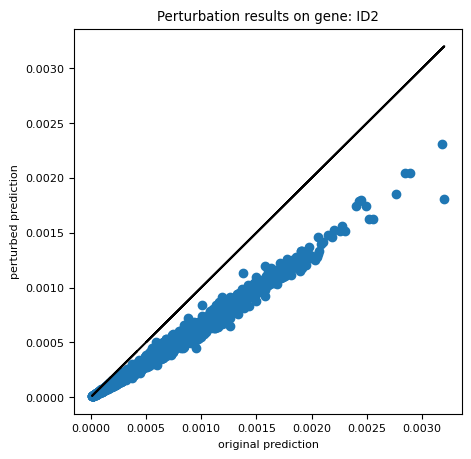

In [12]:
# visualize the silencing effect of the gene itself (one step, will only downregulate)
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

look at responses of all data sorted by cell type

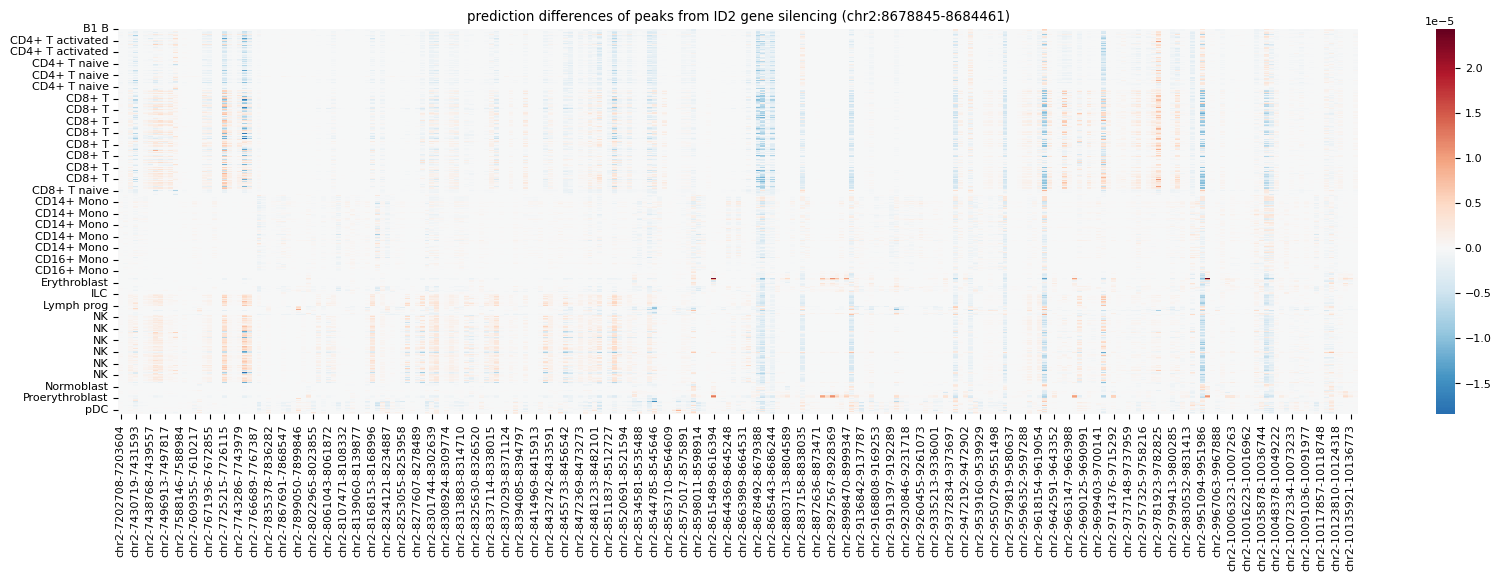

In [13]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location) #because it looks like a gel

In [14]:
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [19]:
# plot the response in emma's window per cell type
# so that we can compare to ground truth
# this just makes the peak windows the same

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
# reindex from 0
df_open_closed = df_open_closed.reset_index(drop=True)
df_open_closed

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:176: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(["position"]).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg["sample_name"] = "negative"


,position,signal,std,cell type,method
0,7.189869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD
1,7.199869,3.251662e-08,2.223402e-07,CD8+ T,multiDGD
2,7.209869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD
3,7.219869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD
4,7.229869,0.000000e+00,0.000000e+00,CD8+ T,multiDGD
...,...,...,...,...,...
6892,10.049873,1.140539e-01,0.000000e+00,negative,HiChIP
6893,10.059873,1.140539e-01,0.000000e+00,negative,HiChIP
6894,10.069873,2.281078e-01,0.000000e+00,negative,HiChIP
6895,10.099873,1.140539e-01,0.000000e+00,negative,HiChIP


In [20]:
# get the 75th percentile of the hichip signals to have something to compare to for binarized data
df_open_closed_hichip = df_open_closed[df_open_closed['method']=='HiChIP'].copy()
thresh_hichip = df_open_closed_hichip['signal'].quantile(0.75)
print(thresh_hichip)

df_pos_intersect = np.sort(df_open_closed['position'].unique())

# now subset the data to these positions
#df_open_closed_hichip = df_open_closed_hichip[df_open_closed_hichip['position'].isin(df_pos_intersect)]

# now binarize the data
df_open_closed_binary_hichip = df_open_closed_hichip.copy()
df_open_closed_binary_hichip['signal'] = df_open_closed_binary_hichip['signal'].apply(lambda x: 1 if x > thresh_hichip else 0)
df_open_closed_binary_dgd = df_open_closed[df_open_closed['method']=='multiDGD'].copy()

0.912431340967266


In [28]:
# save the dataframe
df_open_closed.to_csv(
    save_dir + gene_name + "_hg38_hichip_dgd_aligned_locations_rs37.csv", index=False
)

## Next gene: CD69

In [30]:
gene_name = "CD69"
gene_location = "chr12:9752486-9760901"

file_dir = support_data_dir + "EIS_signal_" + gene_name + "promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print(
    "Gene ID is {} at index {}, peak positions are {}".format(
        gene_id, gene_idx, peak_ids
    )
)

Gene ID is ENSG00000110848 at index 7871, peak positions are [23580, 23581]


In [31]:
#print the gene locations of the two closest peak_ids
print("The two closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The two closest peaks are located at:
23580 chr12-9758433-9759301
23581 chr12-9760649-9761369


### make predictions
the promoter region is actually not contained in any of the peaks, only a rest of the gene is covered

check: modality names are  ['GEX', 'ATAC']
using 2251 samples


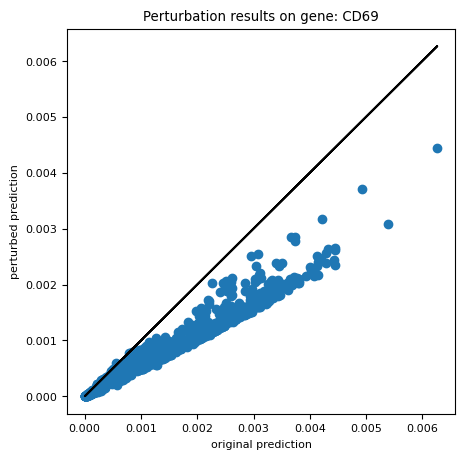

In [32]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

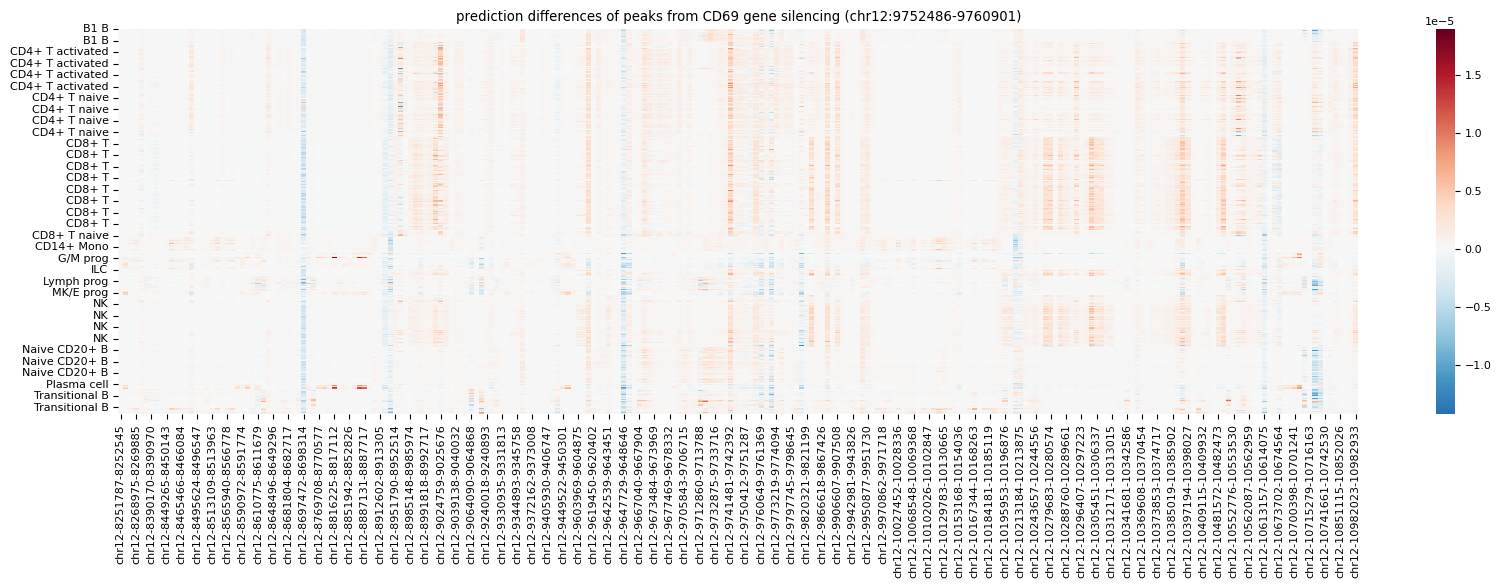

In [33]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [34]:
window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
print(df_hichip['cell type'].unique())

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:176: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(["position"]).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg["sample_name"] = "negative"


['positive' 'negative']


In [35]:
# reindex the dataframe because error in one pandas version
df_open_closed.reset_index(inplace=True, drop=True)
# save the dataframe
df_open_closed.to_csv(
    save_dir + gene_name + "_hg38_hichip_dgd_aligned_locations_rs37.csv", index=False
)

## New gene: CLEC16A

In [36]:
gene_name = "CLEC16A"
gene_location = "chr16:10944539-11182186"

file_dir = support_data_dir + "EIS_signal_" + gene_name + "promoter.hg38.csv"
gene_id, gene_idx = get_gene_ids(gene_name)
peak_ids = find_closest_peak(gene_location)
print(
    "Gene ID is {} at index {}, peak positions are {}".format(
        gene_id, gene_idx, peak_ids
    )
)

Gene ID is ENSG00000038532 at index 9811, peak positions are [39911, 39912, 39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921, 39922, 39923, 39924, 39925, 39926, 39927, 39928, 39929, 39930, 39931, 39932, 39933, 39934]


In [37]:
#print the gene locations of the closest peak_ids
print("The closest peaks are located at:")
for peak_id in peak_ids:
    print(peak_id, testset.var.index[peak_id + modality_switch])

The closest peaks are located at:
39911 chr16-10944074-10944961
39912 chr16-10949108-10950020
39913 chr16-10953661-10954575
39914 chr16-10957700-10958535
39915 chr16-10963807-10964661
39916 chr16-10965751-10966679
39917 chr16-10971345-10971918
39918 chr16-10972033-10972717
39919 chr16-10981505-10982411
39920 chr16-10987226-10988043
39921 chr16-10988340-10989140
39922 chr16-11052152-11053023
39923 chr16-11066180-11066949
39924 chr16-11076040-11076935
39925 chr16-11077716-11078615
39926 chr16-11087881-11088802
39927 chr16-11093909-11094786
39928 chr16-11104837-11105688
39929 chr16-11112648-11113500
39930 chr16-11114461-11115378
39931 chr16-11128453-11129256
39932 chr16-11135156-11136045
39933 chr16-11152774-11153602
39934 chr16-11181618-11182514


there are a lot of peaks containing part of this gene

check: modality names are  ['GEX', 'ATAC']
using 1371 samples


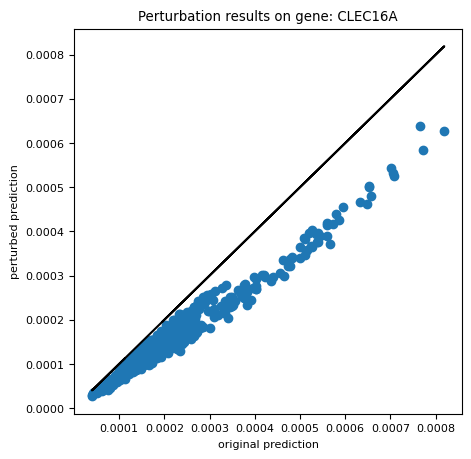

In [38]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=testset, plot=True)

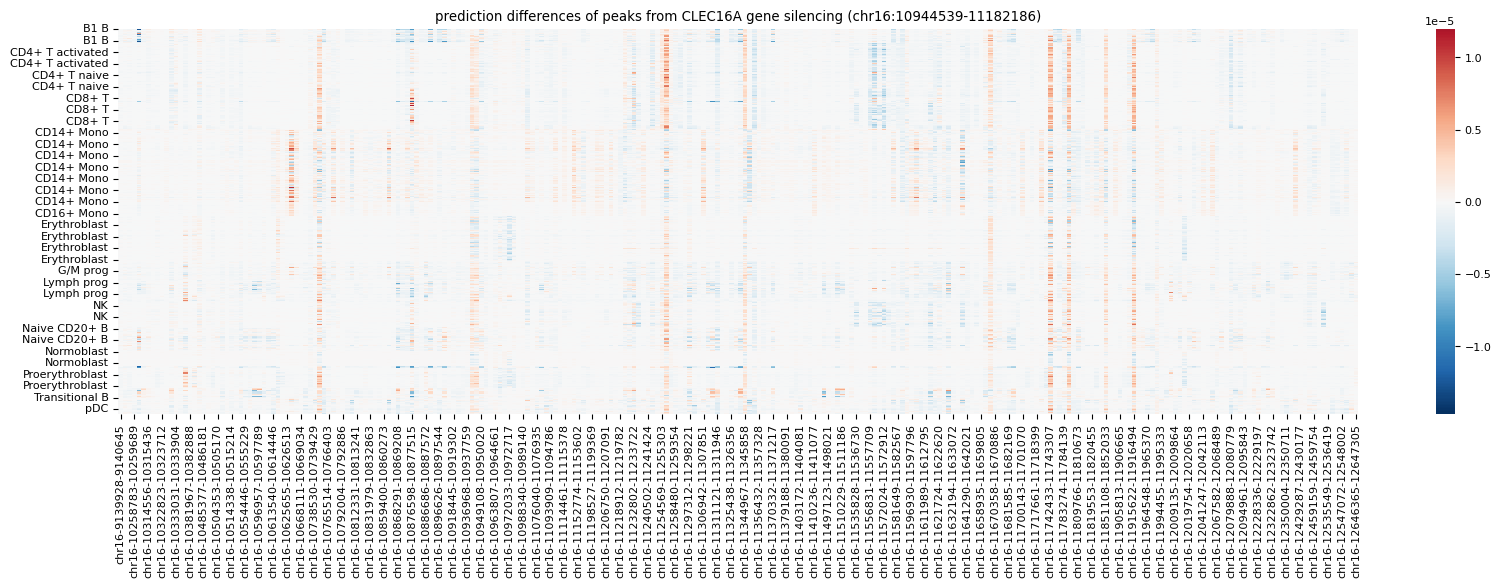

In [39]:
gene_chromosome = gene_location.split(":")[0]
window_start = int(gene_location.split(":")[1].split("-")[0]) - 1500000
window_end = int(gene_location.split(":")[1].split("-")[1]) + 1500000
# find the closest start and end peaks to the window start and end
start_peak, end_peak = find_closest_start_and_end(gene_chromosome, window_start, window_end)

cell_types = testset.obs['cell_type'].values[samples_of_interest]
heatmap_1 = predicted_changes[1][:,start_peak:end_peak]

df_heatmap_1 = plot_gel(heatmap_1, gene_name, gene_location)
cell_types_unique, cell_types_numbers = df_heatmap_1.index.value_counts().index.values, df_heatmap_1.index.value_counts().values

In [40]:
# plot the response in emma's window per cell type

window_size = 10000

df_hichip = prepare_df_emma(file_dir)
df_pos_intersect = np.sort(df_hichip['position'].unique())

for i, ct in enumerate(cell_types_unique):
    bp_location_starts, binned_kb_avg_ct, binned_kb_std_ct = insilico_hichip(df_heatmap_1, [ct], bins=df_pos_intersect, window_size=window_size, norm=False, use_abs=True)
    df_open_closed_temp = pd.DataFrame({
        'position': bp_location_starts,
        'signal': binned_kb_avg_ct,
        'std': binned_kb_std_ct,
        'cell type': ct,
        'method': 'multiDGD'
    })
    if i == 0:
        df_open_closed = df_open_closed_temp
    else:
        df_open_closed = pd.concat([df_open_closed, df_open_closed_temp], axis=0)

df_open_closed = pd.concat([df_open_closed, df_hichip], axis=0)
df_open_closed['position'] = df_open_closed['position'].values / 1e6
df_open_closed

/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:176: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pos = df_pos.groupby(["position"]).mean().reset_index()
/var/folders/tp/pr1hfl8527z35j1791t_j9bc0000gn/T/ipykernel_3376/2874667122.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg["sample_name"] = "negative"


,position,signal,std,cell type,method
0,10.196143,0.000000,0.0,CD14+ Mono,multiDGD
1,10.206143,0.000000,0.0,CD14+ Mono,multiDGD
2,10.216143,0.000000,0.0,CD14+ Mono,multiDGD
3,10.226143,0.000000,0.0,CD14+ Mono,multiDGD
4,10.236143,0.000000,0.0,CD14+ Mono,multiDGD
...,...,...,...,...,...
384,11.636144,3.211834,0.0,negative,HiChIP
385,11.646144,0.802958,0.0,negative,HiChIP
386,11.656144,1.204438,0.0,negative,HiChIP
387,11.666144,1.405177,0.0,negative,HiChIP


In [41]:
# save the dataframe
df_open_closed.to_csv(
    save_dir + gene_name + "_hg38_hichip_dgd_aligned_locations_rs37.csv", index=False
)